## Analytics

1. Optimal time prediction (current day and day out)
2. Peak hours prediction (current day and day out) and calculation

In [231]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pickle
import os
import google.cloud.storage as storage
from dotenv import load_dotenv


# if you are going to run this, youll need to set BUCKET_NAME in .env
load_dotenv()

True

Load test data

In [232]:
df = pd.read_parquet("test_data.parquet")
df.head()

,state,timestamp
0,off,2025-02-01T05:00:00
1,off,2025-02-01T05:02:00
2,off,2025-02-01T05:04:00
3,on,2025-02-01T05:06:00
4,off,2025-02-01T05:08:00


Feature extraction using datetime

In [233]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['day_of_week'] = df['timestamp'].dt.dayofweek
df.head()

,state,timestamp,hour,minute,day_of_week
0,off,2025-02-01 05:00:00,5,0,5
1,off,2025-02-01 05:02:00,5,2,5
2,off,2025-02-01 05:04:00,5,4,5
3,on,2025-02-01 05:06:00,5,6,5
4,off,2025-02-01 05:08:00,5,8,5


Plot raw states of feb 27

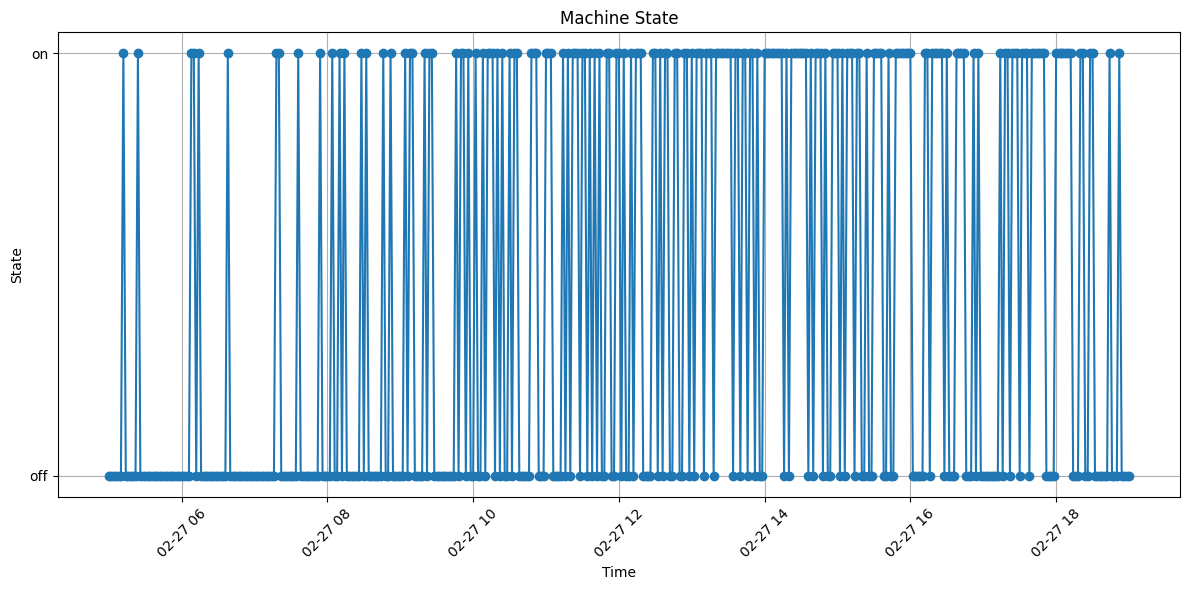

In [234]:
# get feb 27
last_day_df = df[(df['timestamp'] >= '2025-02-27 00:00:00') & (df['timestamp'] <= '2025-02-27 23:59:59')]

plt.figure(figsize=(12, 6))
plt.plot(last_day_df['timestamp'], last_day_df['state'], 'o-')
plt.title('Machine State')
plt.xlabel('Time')
plt.ylabel('State')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Plot % on for feb 27

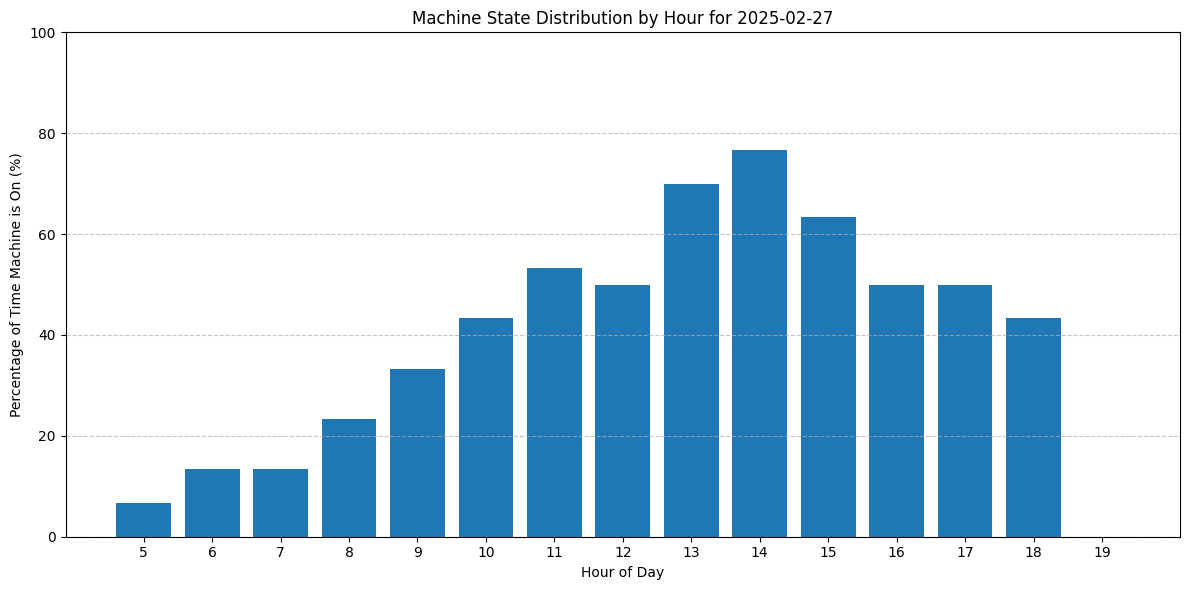

In [235]:
# Calculate percentage of time machine is on for each hour
hourly_stats = last_day_df.groupby('hour')['state'].apply(
    lambda x: (x == 'on').mean() * 100  # Convert to percentage
).reset_index()

day = last_day_df['timestamp'].iloc[0].strftime('%Y-%m-%d')

# Create histogram
plt.figure(figsize=(12, 6))
plt.bar(hourly_stats['hour'], hourly_stats['state'], width=0.8)
plt.title(f'Machine State Distribution by Hour for {day}')
plt.xlabel('Hour of Day')
plt.ylabel('Percentage of Time Machine is On (%)')
plt.xticks(hourly_stats['hour'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)  # Set y-axis from 0 to 100%
plt.tight_layout()
plt.show()

Label encoder

In [236]:
labelEncoder = LabelEncoder()
df['encoded_state'] = labelEncoder.fit_transform(df['state'])
df.head()

,state,timestamp,hour,minute,day_of_week,encoded_state
0,off,2025-02-01 05:00:00,5,0,5,0
1,off,2025-02-01 05:02:00,5,2,5,0
2,off,2025-02-01 05:04:00,5,4,5,0
3,on,2025-02-01 05:06:00,5,6,5,1
4,off,2025-02-01 05:08:00,5,8,5,0


**Feature extraction** (using hour, minute and day of week to predict state)

In [237]:
# for testing, remove the last 8 hours of last day
new_df = df[df['timestamp'] < df['timestamp'].iloc[-1] - pd.Timedelta(hours=8)]

last_timestamp = new_df['timestamp'].iloc[-1]
print("last_timestamp: ", last_timestamp)

X = new_df[["hour", "minute", "day_of_week", "timestamp"]]
y = new_df['encoded_state']

last_timestamp:  2025-02-28 10:58:00


**Train/Test split**: in production, we will train with all previous data on a 12hour schedule. For testing, lets hold out 10% of the data to simulate this.

In [238]:
test_size = int(len(X) * 0.1)

X_train = X[:-test_size]
X_test = X[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

# about 4 days of data to predict.

X_train shape:  (10393, 4)
X_test shape:  (1154, 4)
y_train shape:  (10393,)
y_test shape:  (1154,)


**Train random forest model**: want to predict the 0/1 state given hour, minute, and day of week
- Run grid search for n_estimators parameter (5 fold cross val)

In [239]:
def grid_search(X_train, y_train, features):
    param_grid = {
        'n_estimators': [5, 10, 20, 50, 100, 200]
    }
    model = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5) 
    grid_search.fit(X_train[features], y_train)
    return grid_search

In [240]:
def save_model(model, file_name):
    print("Serializing and saving model to GCP")
    with open(file_name, "wb") as f:
        pickle.dump(model, f)
    storage_client = storage.Client()
    bucket = storage_client.bucket(os.environ.get("MODEL_BUCKET"))
    blob = bucket.blob(file_name)
    blob.upload_from_filename(file_name)
    os.remove(file_name)
    print("Model saved.")

In [241]:
model_features = ["hour", "minute", "day_of_week"]
model = grid_search(X_train, y_train, model_features)
save_model(model, "model.pkl")
print(model.best_params_)

Serializing and saving model to GCP
Model saved.
{'n_estimators': 100}


Predict on test set

In [242]:
predictions = model.predict(X_test[model_features])

results = X_test.copy()
results['predicted_state'] = predictions
results['actual_state'] = y_test
results.head()

,hour,minute,day_of_week,timestamp,predicted_state,actual_state
10393,14,38,1,2025-02-25 14:38:00,1,0
10394,14,40,1,2025-02-25 14:40:00,1,1
10395,14,42,1,2025-02-25 14:42:00,1,0
10396,14,44,1,2025-02-25 14:44:00,0,0
10397,14,46,1,2025-02-25 14:46:00,1,1


Plot predictions vs reality

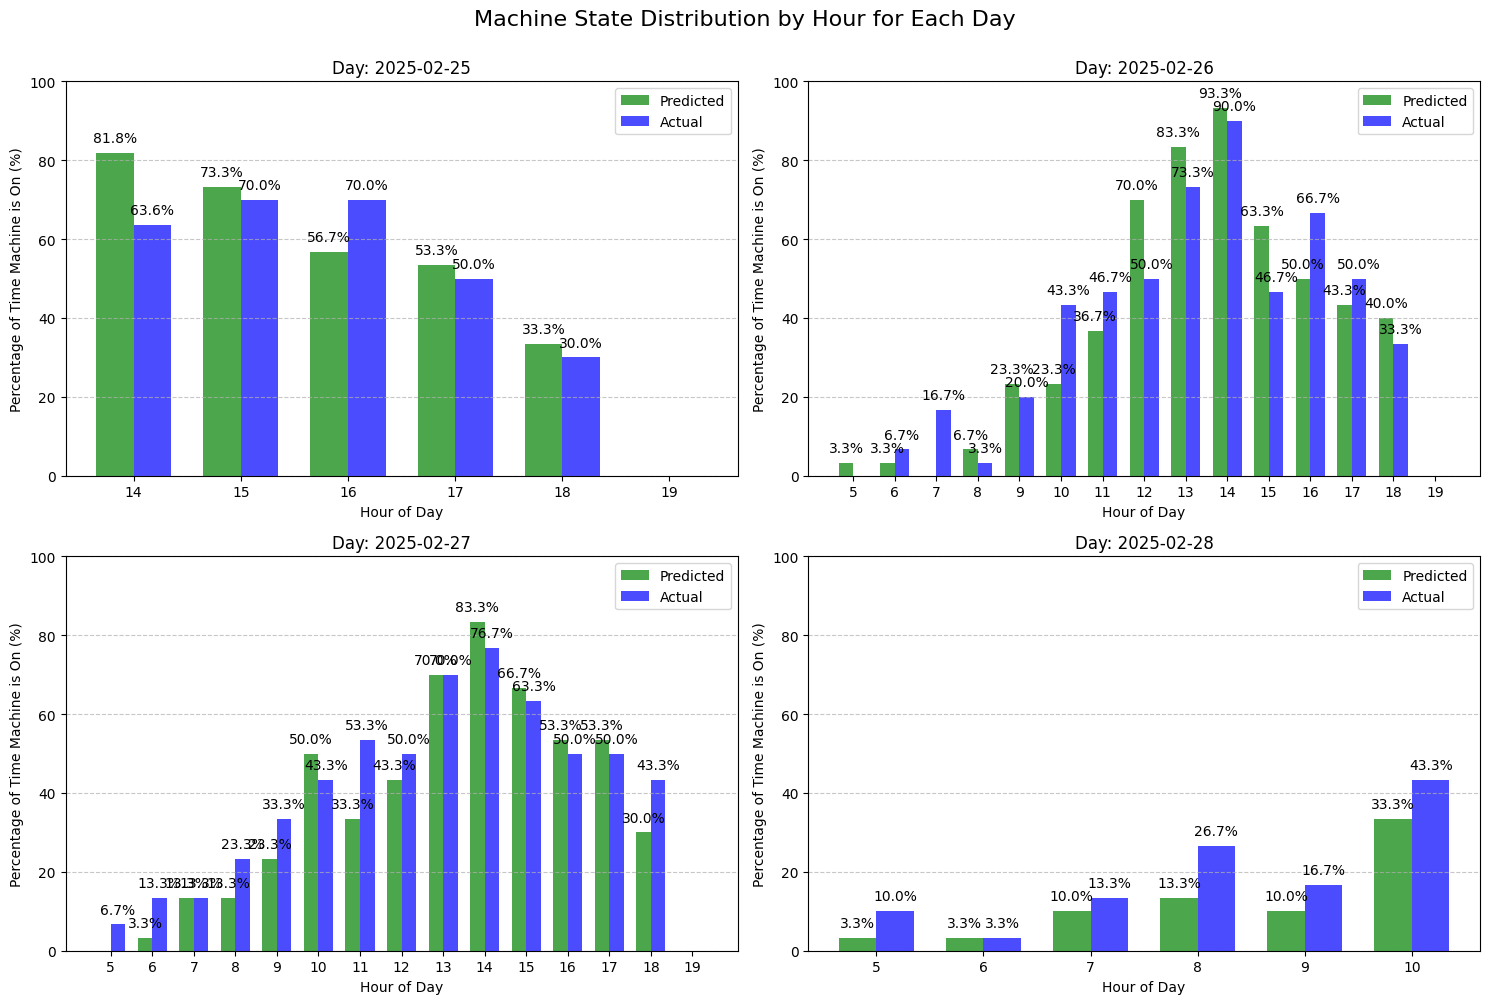

In [243]:
# unique days in the test set
unique_days = results['timestamp'].dt.date.unique()
n_days = len(unique_days)
n_rows = (n_days + 1) // 2 

fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
fig.suptitle('Machine State Distribution by Hour for Each Day', y=1, fontsize=16)
axes = axes.flatten()

# plot for each day in the test set
for i, day in enumerate(unique_days):
    day_data = results[results['timestamp'].dt.date == day]
    
    # average hourly state for predicted and actual
    predicted_stats = day_data.groupby('hour')['predicted_state'].apply(
        lambda x: (x == 1).mean() * 100
    ).reset_index()
    
    actual_stats = day_data.groupby('hour')['actual_state'].apply(
        lambda x: (x == 1).mean() * 100
    ).reset_index()
    
    ax = axes[i]
    width = 0.35
    
    # Plot predicted values
    pred_bars = ax.bar(predicted_stats['hour'] - width/2, 
                      predicted_stats['predicted_state'], 
                      width, 
                      color='green',
                      alpha=0.7,
                      label='Predicted')
    
    # Plot actual values
    actual_bars = ax.bar(actual_stats['hour'] + width/2, 
                        actual_stats['actual_state'], 
                        width, 
                        color='blue',
                        alpha=0.7,
                        label='Actual')
    
    # % labels
    for bar in pred_bars + actual_bars:
        height = bar.get_height()
        if height > 0: 
            ax.text(bar.get_x() + bar.get_width()/2., height + 2,
                   f'{height:.1f}%', ha='center', va='bottom')
    
    ax.set_title(f'Day: {day.strftime("%Y-%m-%d")}')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Percentage of Time Machine is On (%)')
    ax.set_xticks(predicted_stats['hour'])
    ax.set_ylim(0, 100)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.legend()

    # remove empty subplots
    if i == n_days - 1 and n_days % 2 != 0:
        fig.delaxes(axes[i+1])

plt.tight_layout()
plt.show()

Model statistics

In [244]:
# get accuracy, precision, recall, f1 score
accuracy = model.score(X_test[model_features], y_test)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.65
Precision: 0.55
Recall: 0.52
F1 Score: 0.54
